## PNEUMONIA DETECTION

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

from keras.applications.inception_v3 import InceptionV3

from keras import models, layers
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD , RMSprop
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D 
from keras.layers import Flatten, BatchNormalization, Dense

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf

import os

%matplotlib inline

Using TensorFlow backend.



  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


# Image Dataset Preparation

In [2]:
train_dir = './data/train'
test_dir = './data/test'
valid_dir = './data/val'

classes = ['NORMAL', 'PNEUMONIA']

def getImages(_folder, _class):
    total_files = os.listdir(_folder + '/' + _class)
    return total_files

In [3]:
train_files_normal = getImages(train_dir, classes[0])
train_files_pneumonia = getImages(train_dir, classes[1])
len(train_files_normal), len(train_files_pneumonia)

(1341, 3875)

In [4]:
valid_files_normal = getImages(valid_dir, classes[0])
valid_files_pneumonia = getImages(valid_dir, classes[1])
len(valid_files_normal), len(valid_files_pneumonia)

(8, 8)

In [5]:
test_files_normal = getImages(test_dir, classes[0])
test_files_pneumonia = getImages(test_dir, classes[1])
len(train_files_normal), len(test_files_pneumonia)

(1341, 390)

In [6]:
# from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
def plot_figures(figures, nrows = 1, ncols=1):
    # settings
    figsize = [14, 14]     # figure size, inches

    # create figure (fig), and array of axes (ax)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    # plot simple raster image on each sub-plot
    for i, axi in enumerate(ax.flat):
        # axi is equivalent with ax[rowid][colid]
        img = figures[i]
        axi.imshow(img, alpha=0.25)
        
    plt.tight_layout(True)
    plt.show()

plotting sample of train images

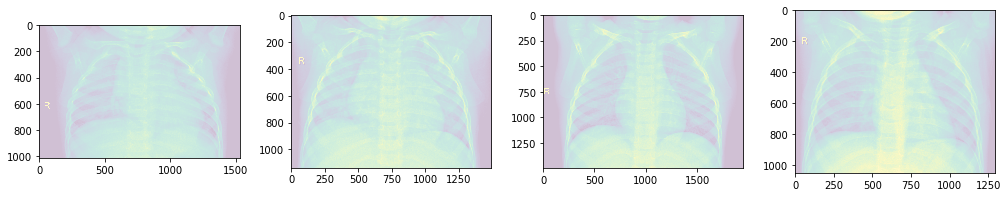

In [7]:
import random

imageQuantity = 4
sample_train_normal = [ mpimg.imread(train_dir + '/' + classes[0] + '/' + train_files_normal[random.randint(0, len(train_files_normal))]) for _ in range(imageQuantity)]
plot_figures(sample_train_normal, 1, 4)


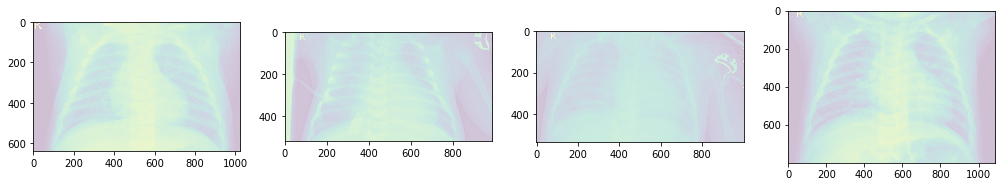

In [8]:
sample_train_pneumonia = [ mpimg.imread(train_dir + '/' + classes[1] + '/' + train_files_pneumonia[random.randint(0, len(train_files_normal))]) for _ in range(imageQuantity)]
plot_figures(sample_train_pneumonia, 1, 4)

# Image Processing

In [9]:
rescale = 1./255
target_size = (150, 150)
batch_size = 32
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=len(valid_files_normal) + len(valid_files_pneumonia),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1,
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Model

In [96]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    x = base_model.output
#     x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D()(x)
#     x = Dense(512, activation='relu')(x)
     # x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    
# #     predictions = Dense(2, activation='sigmoid')(x) 
    predictions = Dense(2, activation='softmax')(x) 
       
    model = Model(inputs=base_model.input, outputs=predictions)
     
    for layer in base_model.layers:
        layer.trainable = False
          
    model.summary()
        
    return model

In [97]:
model = get_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_190 (BatchN (None, 74, 74, 32)   96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 74, 74, 32)   0           batch_normalization_190[0][0]    
__________________________________________________________________________________________________
conv2d_190

# Model training

In [98]:
import datetime

print("Starting Trainning Model", datetime.datetime.now())

steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 10

model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

print("Completed Model Training", datetime.datetime.now())

Starting Trainning Model 2019-09-18 07:38:26.239364
Epoch 1/10
 - 777s - loss: 0.3359 - acc: 0.8643 - val_loss: 2.7235 - val_acc: 0.5000
Epoch 2/10
 - 804s - loss: 0.2415 - acc: 0.9018 - val_loss: 6.3713 - val_acc: 0.5000
Epoch 3/10
 - 831s - loss: 0.2433 - acc: 0.9057 - val_loss: 6.6353 - val_acc: 0.5000
Epoch 4/10
 - 700s - loss: 0.2377 - acc: 0.9105 - val_loss: 6.6470 - val_acc: 0.5000
Epoch 5/10
 - 806s - loss: 0.2296 - acc: 0.9118 - val_loss: 5.3213 - val_acc: 0.5000
Epoch 6/10
 - 792s - loss: 0.2340 - acc: 0.9116 - val_loss: 5.5746 - val_acc: 0.5000
Epoch 7/10
 - 842s - loss: 0.2315 - acc: 0.9095 - val_loss: 4.0435 - val_acc: 0.5000
Epoch 8/10
 - 792s - loss: 0.2217 - acc: 0.9151 - val_loss: 5.5398 - val_acc: 0.5000
Epoch 9/10
 - 780s - loss: 0.2416 - acc: 0.9097 - val_loss: 4.3296 - val_acc: 0.5000
Epoch 10/10
 - 810s - loss: 0.2291 - acc: 0.9139 - val_loss: 2.4326 - val_acc: 0.5625
Completed Model Trainning 2019-09-18 09:50:42.495214


In [99]:
model.save('pneumonia_model.h5')

# Model Evaluation

In [10]:
model = models.load_model('pneumonia_model.h5')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=2)
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 1.8983266688477016
Accuracy: 0.6778846153846154


In [12]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

624/624 [==============================] - 95s 152ms/step


In [13]:
precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred)

print('Precision: {}'.format(precision))
print('Recall:    {}'.format(recall))
print('F1:        {}'.format(f1))

Precision: 0.6735459662288931
Recall:    0.9205128205128205
F1:        0.7778981581798483


In [14]:
#from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

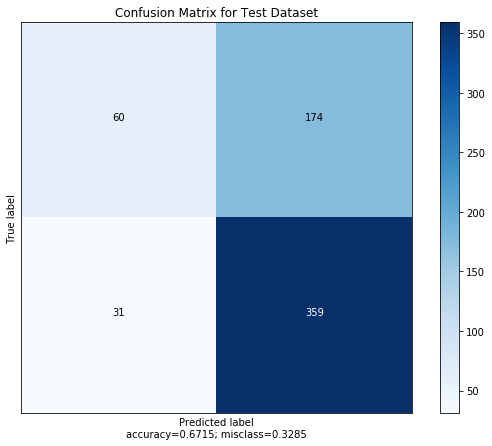

In [15]:
CM = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm = CM, normalize = False, target_names = [], title = "Confusion Matrix for Test Dataset")

# Sample Test Visualization

In [16]:
# from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
def plot_test_figures(figures, true, pred, nrows = 1, ncols=1):
    # settings
    figsize = [14, 14]     # figure size, inches

    # create figure (fig), and array of axes (ax)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    # plot simple raster image on each sub-plot
    for i, axi in enumerate(ax.flat):
        # axi is equivalent with ax[rowid][colid]
        img = figures[i]
        axi.imshow(img, alpha=0.25)
        axi.set_title('true: {}, pred: {}'.format(true[i], pred[i]))
        
    plt.tight_layout(True)
    plt.show()

[1, 1, 0, 1]
[1, 1, 1, 1]


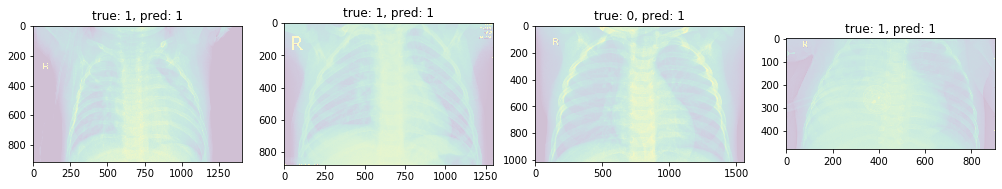

In [22]:
imageQuantity = 4

sample_test_image = []
sample_test_filename = []
sample_test_true_result = []
sample_test_pred_result = []

for _ in range(imageQuantity):
    pos = random.randint(0, len(test_generator))
    
    img = mpimg.imread(test_dir + '/' + test_generator.filenames[pos].replace('\\','/')) 
    
    sample_test_image.append(img)
    sample_test_true_result.append(test_generator.classes[pos])
    sample_test_pred_result.append(y_pred[pos])

#print(sample_test_pneumonia)    
print(sample_test_true_result)
print(sample_test_pred_result)

plot_test_figures(sample_test_image, sample_test_true_result, sample_test_pred_result, 1, 4 )
